# Cheminformatics in Python: Predicting Solubility of Molecules

This notebook will be my attempt at reproducing a research article (John S. Delaney) by applying linear regression to predict molecule solubility (an important physiocochemical property in drug discovery reasearch) referencing . 

## 1. Install rdkit

In [1]:
#!conda install -c rdkit rdkit -y
import sys
!conda install --yes --prefix {sys.prefix} rdkit rdkit

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\frisk\anaconda3

  added / updated specs:
    - rdkit


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.12.0-py39hcbf530~ --> pkgs/main::conda-4.12.0-py39haa95532_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


## 2. Delaney's solubility dataset

The original Delaney's dataset is available as a supplementary file. The full paper is entitled: ESOL Estimating Aqueous Solubility Directly from Molecular Structure.

### 2.1 Download the dataset

In [20]:
import wget
wget.download('https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt')

HTTPError: HTTP Error 403: Forbidden

The dataset could not be downloaded from the original source thus a version hosted by Chanin Nantasenamat was used.

In [25]:
wget.download('https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv')

100% [..............................................................................] 58889 / 58889

'delaney.csv'

### 2.2 Read in the dataset

In [28]:
import pandas as pd 
solubility_Data = pd.read_csv('delaney.csv')
solubility_Data

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### 2.3 Examining the SMILES data

Chemical strutures are encoded by a string of text known as **SMILES** which as an acronym for **Simplified Molecular-Input Line-Entry System**.

In [35]:
solubility_Data.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [37]:
solubility_Data.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### 2.4 Convert a molecule from the SMILES string to an rdkit object

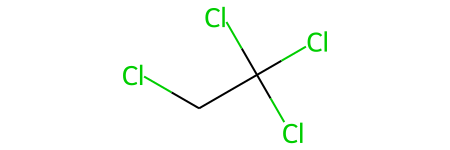

In [40]:
from rdkit import Chem
Chem.MolFromSmiles(solubility_Data.SMILES[0])

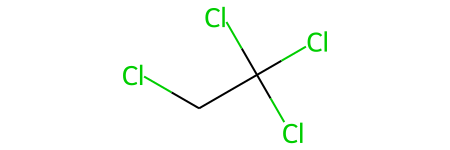

In [46]:
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

### 2.5 Computing atoms in molecule with rdkit

In [48]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [50]:
m.GetNumAtoms()

6

## 3. Calculate the molecular descriptors in rdkit

### 3.1 Convert list of molecules to rdkit object

In [51]:
from rdkit import Chem

#### 3.1.1 Method 1 (looping)

In [54]:
mol_list=[] # Initialize Molecule array
for element in solubility_Data.SMILES: ## Loop over each entry in the Smiles column of the downloaded 'solubility_Data'
    mol = Chem.MolFromSmiles(element)
    mol_list.append(mol)

In [55]:
# Checking the length of molecule list
len(mol_list)

1144

In [56]:
# Checking the first five molecules
mol_list[:5]

#### 3.1.2 Method 2

In [59]:
mol_list2 = [Chem.MolFromSmiles(element) for element in solubility_Data.SMILES]

In [60]:
# Checking the length of molecule list
len(mol_list2)

1144

In [61]:
# Checking the first five molecules
mol_list[:5]

### 3.2 Calculate molecular descriptors 

To predict LogS (Log of the aqueous solubility), Delaney's study suggests the use of 4 molecular predictors. 
* 1. cLogP (Octanol-water partition coefficient)
* 2. MW (Molecular Weight)
* 3. RB  (Number of rotatable bonds)
* 4. AP (Aromatic Proportion = number of aromatic atoms/ total number of heavy atoms)

Rdkit readily computes the first 3 parameters. AP (Aromatic Proportion) on the other hand, must be manually computed using the ratio of the number of aromatic atoms to the toal number of heavy atoms,

#### 3.2.1 LogP, MW, and RB

In [71]:
import numpy as np
from rdkit.Chem import Descriptors

In [82]:
def generate(smiles, verbose=False):
    
    moldata=[]
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
    
    baseData = np.arange(1,1)
    i=0
    for mol in moldata:
        
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        
        row = np.array([desc_MolLogP,
                       desc_MolWt,
                       desc_NumRotatableBonds])
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData,row])
        i=i+1
        
    columnNames = ["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    
    return descriptors

In [84]:
df = generate(solubility_Data.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### 3.2.2 Calculate Aromatic Proportion

##### 3.2.2.1 Number of aromatic atoms

A Custom function will be defined to calculate the number of aromatic atoms. This can subsequently be used to calculate the AP descriptor.

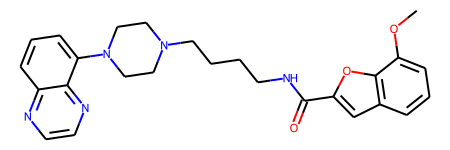

In [86]:
# Computing for a single molecule 
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
m

In [87]:
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [88]:
def AromaticAtoms(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aa_count=[]
    for i in aromatic_atoms:
        if i==True:
            aa_count.append(1)
    sum_aa_count=sum(aa_count)
    return sum_aa_count

In [89]:
AromaticAtoms(m)

19

In [90]:
# Compute for all molecules in the datset
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

##### 3.2.2.2 Number of heavy atoms

In [93]:
# Testing with a single molecule
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

In [94]:
# Computing for all the molecules
desc_heavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_heavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

##### 3.2.2.3 Computing the Aromatic Proportion (AP) descriptor

In [96]:
# Computing for a single molecule
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

In [97]:
# Computing for molecules in the entire dataset
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [100]:
# Converting the calculated Aromatic Porportion descriptors to a dataframe
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=["AromaticProportion"])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### 3.3 X matrix (combining all descriptors into 1 dataframe)

In [101]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [103]:
X=pd.concat([df,df_desc_AromaticProportion],axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### 3.4 Y matrix

In [104]:
Y = solubility_Data.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

## 4. Data Split

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

## 5. Creating the Linear Rregression Model

In [107]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [109]:
# Creating and fitting the model to the data
model = linear_model.LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

### 5.1 Predicting from the X_train

In [110]:
y_pred_train = model.predict(X_train)

In [112]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_train,y_pred_train))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_train,y_pred_train))

Coefficients: [-0.72785643 -0.00673893  0.00189424 -0.47663772]
Intercept: 0.3000375159903945
Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.77


### 5.2 Predicting from the X_test

In [113]:
y_pred_test = model.predict(X_test)

In [114]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test,y_pred_test))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_test,y_pred_test))

Coefficients: [-0.72785643 -0.00673893  0.00189424 -0.47663772]
Intercept: 0.3000375159903945
Mean squared error (MSE): 1.07
Coefficient of determination (R^2): 0.77


**Our Linear Regression Equation**

In [115]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.30 -0.73 LogP -0.0067 MW 0.0019 RB -0.48 AP


### 5.3 Comparing versus training based on the entire dataset

In [117]:
# Create and fit the model
full_model = linear_model.LinearRegression()
full_model.fit(X,Y)

LinearRegression()

In [118]:
# Create predictions
full_model_pred = model.predict(X)

In [119]:
print('Coefficients:', full_model.coef_)
print('Intercept:', full_model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y,full_model_pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y,full_model_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.25650068309971985
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


## 6. Scatter plot of experimental vs predicted logS

In [120]:
import matplotlib.pyplot as plt

In [121]:
# Checking the dimensions of the train and test sets
y_train.shape,y_pred_train.shape

((915,), (915,))

In [122]:
y_test.shape,y_pred_test.shape

((229,), (229,))

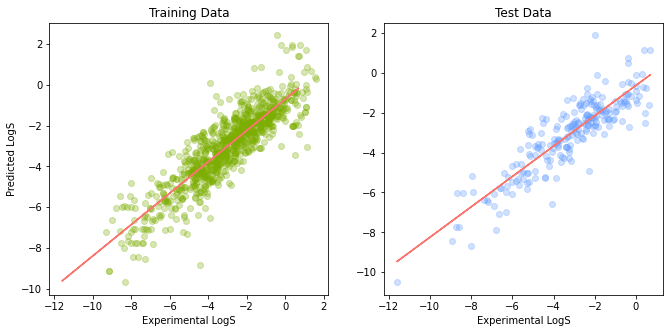

In [123]:
plt.figure(figsize=(11,5))

# 1 Row 2 column - subplot 1
plt.subplot(1,2,1)
plt.scatter(x=y_train, y=y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(y_train,y_pred_train,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel("Predicted LogS")
plt.xlabel("Experimental LogS")
plt.title("Training Data")

# 1 row 2 column - subplot 2
plt.subplot(1,2,2)
plt.scatter(x=y_test, y=y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test,y_pred_test,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")
plt.xlabel('Experimental LogS')
plt.title("Test Data")
# Saving Files
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()